In [1]:
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, IBMQ, execute
from qiskit.quantum_info import *
from qiskit.ignis.verification import *

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np

In [2]:
from qiskit.extensions import UnitaryGate
from numpy import sqrt, array

arr = 1/sqrt(2)*array([[1,-1],[1,1]], dtype = 'complex')
P = UnitaryGate(arr)
Q = UnitaryGate(arr)

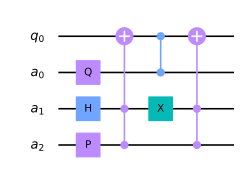

In [3]:
#Quantum Switch simulator circuit definition

q = QuantumRegister(1, name='q')
a = QuantumRegister(3, name='a')

QS = QuantumCircuit(q,a)

QS.unitary(Q, [a[0]], label='Q')
QS.unitary(P, [a[2]], label='P')
QS.h(a[1])
QS.toffoli(a[1],a[2],q[0])
QS.x(a[1])
QS.cz(a[0],q[0])
QS.toffoli(a[1],a[2],q[0])

QS.draw(output='mpl', plot_barriers=False, scale=0.8)

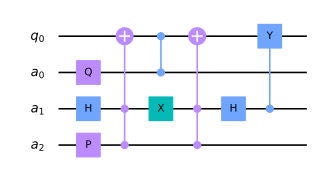

In [5]:
#Post-processing

QS.h(a[1])
QS.cy(a[1],q[0])

QS.draw(output='mpl', plot_barriers=False, scale=0.8)

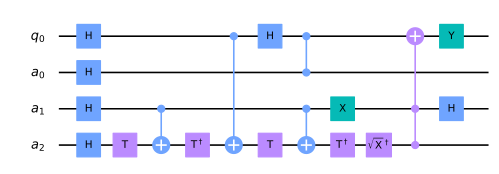

In [7]:
#Optimized version of the Quantum Switch simulator with post-processing operation

p = QuantumRegister(1, name='q')
b = QuantumRegister(3, name='a')

OPT_QS = QuantumCircuit(p,b)

#init
OPT_QS.h(b)

#opt-toffoli
OPT_QS.t(b[2])
OPT_QS.cx(b[1], b[2])
OPT_QS.tdg(b[2])
OPT_QS.h(p[0])
OPT_QS.cx(p[0],b[2])
OPT_QS.t(b[2])
OPT_QS.h(p[0])
OPT_QS.cx(b[1], b[2])
OPT_QS.tdg(b[2])
OPT_QS.sxdg(b[2])

OPT_QS.x(b[1])
OPT_QS.cz(b[0],p[0])

OPT_QS.toffoli(b[2],b[1],p[0])

#post-processing
OPT_QS.h(b[1])
OPT_QS.y(p[0])

OPT_QS.draw(output='mpl', plot_barriers=False, scale=0.8)

In [9]:
CHOI_ID = array([[1,0,0,1],[0,0,0,0],[0,0,0,0],[1,0,0,1]], dtype = 'complex')

In [10]:
#QPT conditioned on control qubit

CIRCUITS = process_tomography_circuits(OPT_QS, q[0])

qst_ghz_no_anc = deepcopy(CIRCUITS)
ca = ClassicalRegister(1)
for qst_ghz_circ in CIRCUITS:
    qst_ghz_circ.add_register(ca)
    qst_ghz_circ.measure(a[1],ca[0])

In [11]:
provider = IBMQ.get_provider('ibm-q-research')
BACKEND = provider.get_backend('ibmq_qasm_simulator')

j = execute(CIRCUITS, backend=BACKEND, shots=8192)

In [12]:
raw_results = j.result()
new_result = deepcopy(raw_results)

for resultidx, _ in enumerate(raw_results.results):
    old_counts = raw_results.get_counts(resultidx)
    new_counts = {}

    #change the size of the classical register
    new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
    new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-1]
    new_result.results[resultidx].header.memory_slots = 1

    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0]=='1':
            new_counts[reg_bits[1]]=old_counts[reg_key]

        new_result.results[resultidx].data.counts = new_counts

fitter = ProcessTomographyFitter(new_result, qst_ghz_no_anc)
CHOI_EX = fitter.fit().data

In [13]:
state_fidelity(CHOI_ID/2, CHOI_EX/2, validate = False)

0.9926344221766155